
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from agents.beacs import BEACS, BEACSConfiguration

# Load particular Environment Adapter
from my_examples.adapter.MountainCarEnvironmentAdapter import MountainCarEnvironmentAdapter

# Load Metrics
from my_examples.metrics.MountainCarMetrics import _mountaincar_metrics

# Load Plotting Wrappers
from my_examples.metrics.MountainCarPlottingWrapper import \
    parse_metrics_to_df, \
    plot_mountaincar_performance, \
    plot_average_mountaincar_performance

# Load environments
import gym

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
CLASSIFIER_LENGTH = 2
NUMBER_OF_POSSIBLE_ACTIONS = 3
MOUNTAINCAR = "MountainCar-v0"
POS_BUCKETS = 5
VEL_BUCKETS = 4
MAX_EPISODE_STEPS = 1000

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 100
METRICS_TRIAL_FREQUENCY_EXPLORE = 1
EPSILON = 0.50
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS = 5000

#RL Set Up
GAMMA = 0.99
BETA_RL = 0.1

#BEACS Set Up
ENABLE_EP = True

#CRACS Set up
APPLY_CRACS = True
CRACS_KEEP_UNRELIABLE = False

#Seed
SEED = 42

## Environment - MountainCar

In [3]:
# Initialize environment
MountainCar = gym.make(MOUNTAINCAR)
# To update the maximal number of step in a unique episode 
MountainCar._max_episode_steps = MAX_EPISODE_STEPS
# Reset it, by putting an agent into random position
state, _info = MountainCar.reset(seed=SEED)

## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    environment_adapter=MountainCarEnvironmentAdapter(POS_BUCKETS, VEL_BUCKETS),
    user_metrics_collector_fcn=_mountaincar_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_ep=ENABLE_EP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=0.,
    chi=0.,
    bs_max=0,
    seed=SEED
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(MountainCar, NUMBER_OF_EXPLORE_TRIALS)

/Users/romain/miniconda3/envs/alcs/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


CPU times: user 33.8 s, sys: 371 ms, total: 34.2 s
Wall time: 37.6 s


### Performance

In [5]:
print(_mountaincar_metrics(population_explore, MountainCar))

if APPLY_CRACS:
    agent_explore.apply_CRACS(keep_unreliable=CRACS_KEEP_UNRELIABLE)
    population_explore = agent_explore.get_population()

print(_mountaincar_metrics(population_explore, MountainCar))

{'population': 54, 'numerosity': 1080, 'reliable': 54}
{'population': 54, 'numerosity': 1080, 'reliable': 54}


/Users/romain/miniconda3/envs/alcs/lib/python3.10/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Average number of reward to solve the mountaincar is  -958.84  for a total of  100  trials in EXPLORATION
Maximum average achieved: -958.84 for 100 episodes


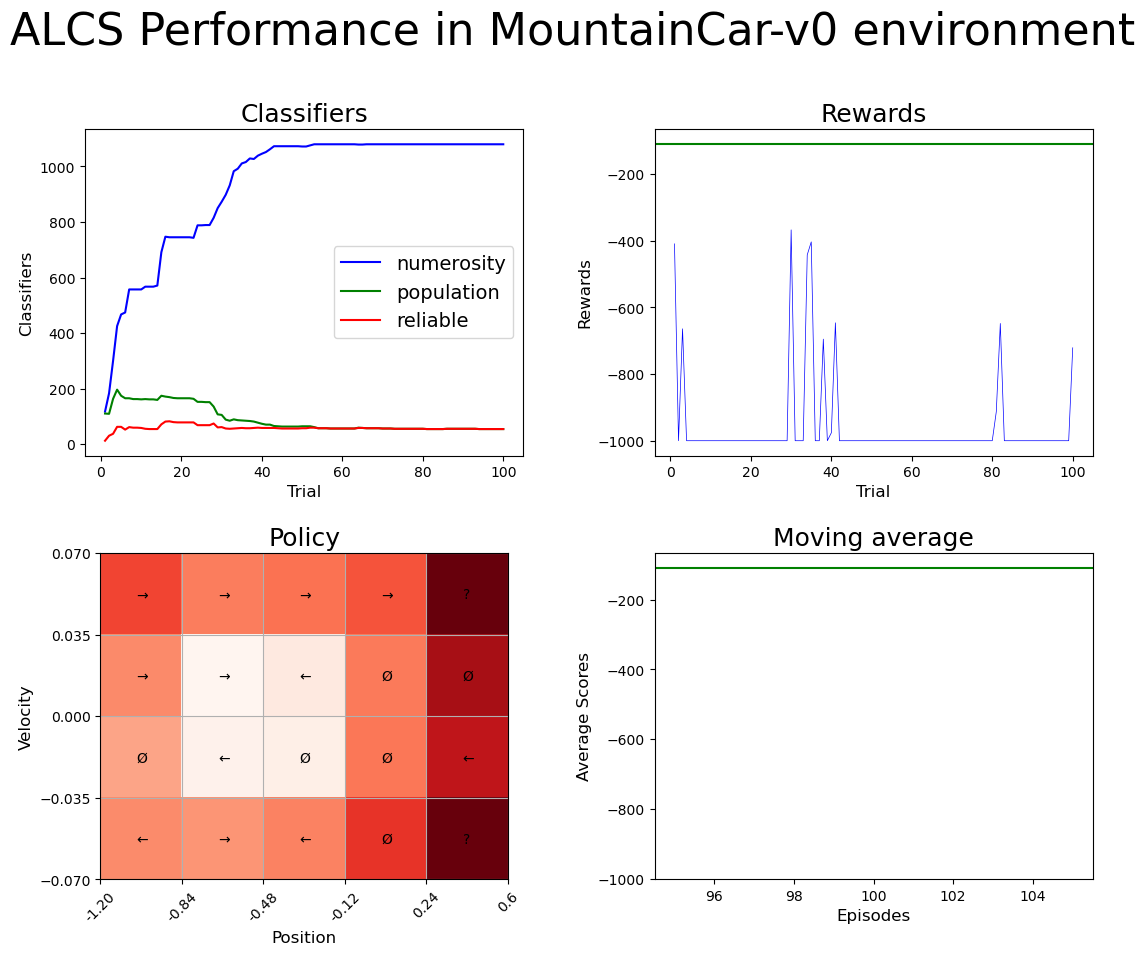

In [6]:
metrics_df = parse_metrics_to_df(metrics_explore, METRICS_TRIAL_FREQUENCY_EXPLORE, None)
plot_mountaincar_performance(metrics_df, MOUNTAINCAR, METRICS_TRIAL_FREQUENCY_EXPLORE, NUMBER_OF_EXPLORE_TRIALS, None, population_explore, POS_BUCKETS, VEL_BUCKETS, metrics_explore, None)

In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
print(len(population_explore_to_display))
print("\n")
for cl in population_explore_to_display[:]:
    print(cl)
    print("\n")

54


C:5.3 A:1 None E:(#.2:16, #.#:218)
q: 1.0    r: -7.178 r_bis: -6.37  ir: -1.0   f: -6.37  err: 1.529 
exp: 233   num: 20 ee: False
Mark: empty Can_be_generalized: [True, False] Aliased_state: 5.3 PAI_state: 
tga: 95879 tbseq: 31081 talp: 95883 tav: 270.9  



C:5.3 A:2 None E:(#.#:298, #.2:5)
q: 1.0    r: -6.969 r_bis: -7.012 ir: -1.0   f: -6.969 err: 0.9535
exp: 302   num: 20 ee: False
Mark: empty Can_be_generalized: [True, False] Aliased_state: 5.3 PAI_state: 
tga: 95880 tbseq: 27795 talp: 95880 tav: 264.5  



C:5.3 A:0 None E:(#.2:36, #.#:191, 4.2:3)
q: 1.0    r: -7.417 r_bis: -7.819 ir: -1.0   f: -7.417 err: 1.208 
exp: 186   num: 20 ee: False
Mark: empty Can_be_generalized: [False, False] Aliased_state: 5.3 PAI_state: 
tga: 95783 tbseq: 31191 talp: 95883 tav: 343.2  



C:5.2 A:0 None E:(#.#:128, 4.#:20)
q: 1.0    r: -13.53 r_bis: -10.03 ir: -1.0   f: -10.03 err: 3.683 
exp: 147   num: 20 ee: False
Mark: empty Can_be_generalized: [False, True] Aliased_state: 5.2 PAI_state: 


## Training of BEACS - Exploitation

In [8]:
%%time

cfg_exploit = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    environment_adapter=MountainCarEnvironmentAdapter(POS_BUCKETS, VEL_BUCKETS),
    user_metrics_collector_fcn=_mountaincar_metrics,
    metrics_trial_frequency=1,
    do_ep=ENABLE_EP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=0.,
    u_max=CLASSIFIER_LENGTH,
    mu=0.,
    chi=0.,
    bs_max=0,
    seed=SEED
)

agent_exploit = BEACS(cfg_exploit, population_explore)
population_exploit, metrics_exploit = agent_exploit.exploit(MountainCar, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 2min, sys: 1.5 s, total: 2min 2s
Wall time: 2min 24s


### Performance

Average number of reward to solve the mountaincar is  -958.84  for a total of  100  trials in EXPLORATION
Average number of rewards to solve the mountaincar is  -135.26  for a total of  5000  trials in EXPLOITATION with Reinforcement Module
Average number of rewards to solve the mountaincar is  -106.46  for the last 100 trials in EXPLOITATION with Reinforcement Module
Solved requirements at episode 1743: average -109.46 for 100 episodes
Maximum average achieved: -103.23 for 100 episodes


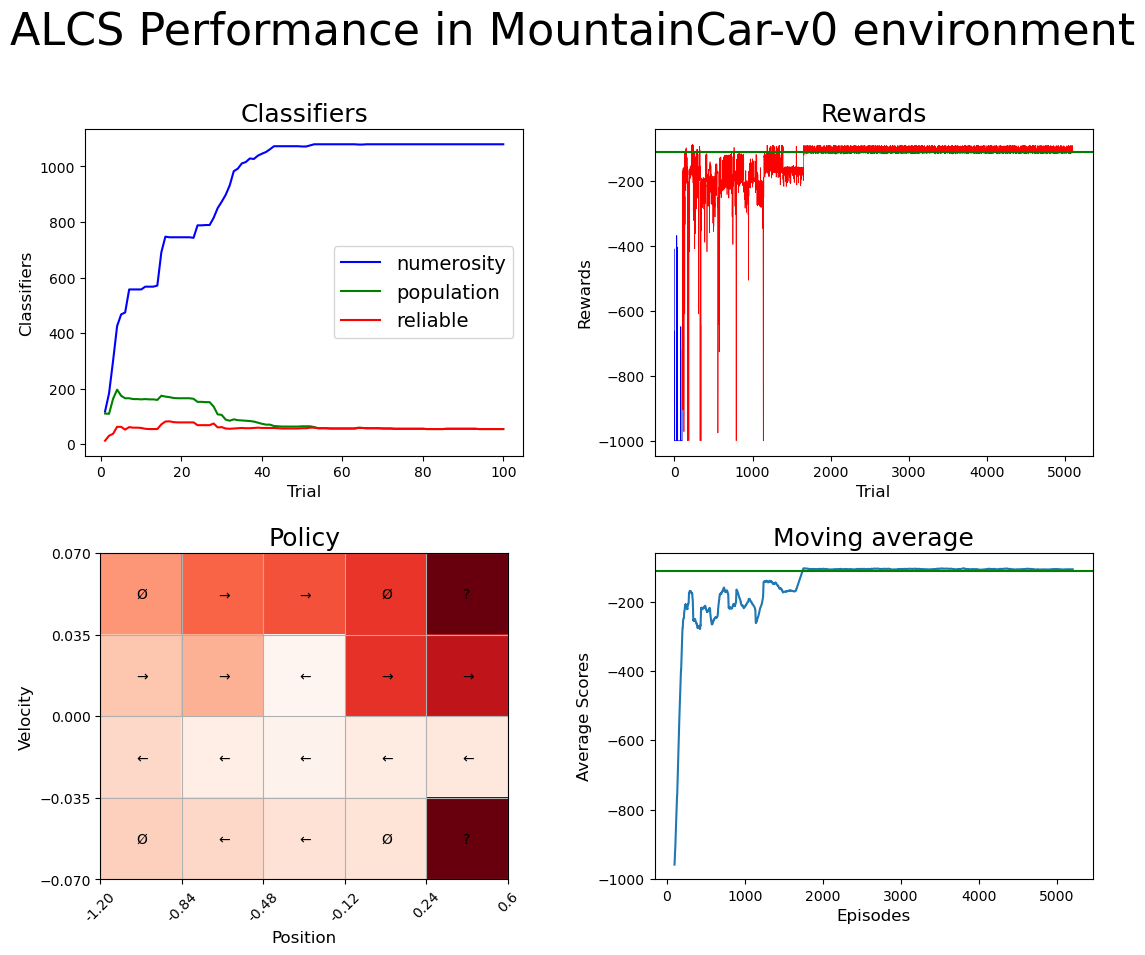

In [9]:
metrics_df = parse_metrics_to_df(metrics_explore, METRICS_TRIAL_FREQUENCY_EXPLORE, metrics_exploit)
plot_mountaincar_performance(metrics_df, MOUNTAINCAR, METRICS_TRIAL_FREQUENCY_EXPLORE, NUMBER_OF_EXPLORE_TRIALS, NUMBER_OF_EXPLOIT_TRIALS, population_exploit, POS_BUCKETS, VEL_BUCKETS, metrics_explore, metrics_exploit)

In [10]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit]
print(len(population_exploit_to_display))
print("\n")
for cl in population_exploit_to_display[:]:
    print(cl)
    print("\n")

54


C:5.3 A:2 None E:(#.#:298, #.2:5)
q: 1.0    r: -15.82 r_bis: -14.45 ir: -1.0   f: -14.45 err: 2.484 
exp: 302   num: 20 ee: False
Mark: empty Can_be_generalized: [True, False] Aliased_state: 5.3 PAI_state: 
tga: 95880 tbseq: 27795 talp: 95880 tav: 264.5  



C:4.3 A:2 None E:(#.#:1263, #.2:57, 5.#:25)
q: 1.0    r: -24.14 r_bis: -23.42 ir: -1.0   f: -23.42 err: 2.062 
exp: 1336  num: 20 ee: False
Mark: empty Can_be_generalized: [False, False] Aliased_state: 4.3 PAI_state: 
tga: 95687 tbseq: 1966  talp: 95775 tav: 60.13  



C:5.3 A:1 None E:(#.2:16, #.#:218)
q: 1.0    r: -24.48 r_bis: -24.15 ir: -1.0   f: -24.15 err: 1.269 
exp: 233   num: 20 ee: False
Mark: empty Can_be_generalized: [True, False] Aliased_state: 5.3 PAI_state: 
tga: 95879 tbseq: 31081 talp: 95883 tav: 270.9  



C:5.3 A:0 None E:(#.2:36, #.#:191, 4.2:3)
q: 1.0    r: -24.19 r_bis: -29.44 ir: -1.0   f: -24.19 err: 4.079 
exp: 186   num: 20 ee: False
Mark: empty Can_be_generalized: [False, False] Aliased_state: 5.3 PA